# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torch
# Define transforms for the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
first_indices = list(range(100))
Xtrain = torch.utils.data.Subset(train_dataset, first_indices)
Xtrain_loader = torch.utils.data.DataLoader(Xtrain, batch_size=10, shuffle=True)

second_indices = list(range(100, len(train_dataset)))
X = torch.utils.data.Subset(train_dataset, second_indices)
X_loader = torch.utils.data.DataLoader(X, batch_size=10, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test) 
Xtest_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

First, it is hard to define a clear criteria before we finished training. Usually, we evaluate models according to the performance, which means only after testing procedure we are more aware of trained models. Then, the difficulty relates to complex dynamic environment because during the training procedure, the coefficients and parameters are updated along with time. Even there is corresponding criteria for evaluation, probably, the value of parameters could outperform in next few iterations or steps. At the meantime, it definitely takes up more space or capability, which would lead to longer training time and poorer output. Besides, overfitting could be an issue if the training procedure follows evaluation too well. Therefore, how to avoid overfitting by having training evaluated well would be another challenge.


Possible solutions:
* Split data into training set and validation set to evaluate;
* More clear architecture of models so that it might be easier to add evaluation steps;
* Define more explicit standard if on the data that could be easily supervised.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the CNN model
model = Net().to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
# Train the model for the specified number of epochs
num_epochs = 100

In [ ]:
# Train CNN
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(Xtrain_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Calculate the running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    scheduler.step()
    # Print statistics
    print('Epoch %d, Loss: %.3f, Accuracy: %.3f%%' %
          (epoch + 1, running_loss / len(Xtrain_loader),
           100 * correct / total))

Epoch 1, Loss: 2.298, Accuracy: 13.000%
Epoch 2, Loss: 2.270, Accuracy: 16.000%
Epoch 3, Loss: 2.259, Accuracy: 16.000%
Epoch 4, Loss: 2.253, Accuracy: 16.000%
Epoch 5, Loss: 2.242, Accuracy: 13.000%
Epoch 6, Loss: 2.243, Accuracy: 16.000%
Epoch 7, Loss: 2.216, Accuracy: 15.000%
Epoch 8, Loss: 2.231, Accuracy: 18.000%
Epoch 9, Loss: 2.215, Accuracy: 19.000%
Epoch 10, Loss: 2.201, Accuracy: 20.000%
Epoch 11, Loss: 2.182, Accuracy: 27.000%
Epoch 12, Loss: 2.151, Accuracy: 21.000%
Epoch 13, Loss: 2.137, Accuracy: 21.000%
Epoch 14, Loss: 2.065, Accuracy: 26.000%
Epoch 15, Loss: 2.106, Accuracy: 27.000%
Epoch 16, Loss: 2.009, Accuracy: 30.000%
Epoch 17, Loss: 2.008, Accuracy: 28.000%
Epoch 18, Loss: 1.994, Accuracy: 30.000%
Epoch 19, Loss: 1.865, Accuracy: 30.000%
Epoch 20, Loss: 1.983, Accuracy: 24.000%
Epoch 21, Loss: 1.900, Accuracy: 34.000%
Epoch 22, Loss: 1.871, Accuracy: 30.000%
Epoch 23, Loss: 1.840, Accuracy: 29.000%
Epoch 24, Loss: 1.805, Accuracy: 37.000%
Epoch 25, Loss: 1.779, Ac

In [ ]:
# Evaluate the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in Xtest_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the %d test images: %d %%' % (len(Xtest_loader.dataset), 100 * correct / total))

Accuracy of the network on the 10000 test images: 24 %


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])
def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())
test()

torch.Size([1, 10])


In [ ]:
model = ResNet18().to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
# Train the model for the specified number of epochs
num_epochs = 100

In [ ]:
# Evaluate the network
def evaluate(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Train the network
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(Xtrain_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Calculate the running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    scheduler.step()
    # Print statistics
    print('Epoch %d, Loss: %.3f, Accuracy: %.3f%%' %
          (epoch + 1, running_loss / len(Xtrain_loader),
           100 * correct / total))
    
print('Accuracy on test set after training: %f%%' % evaluate(model, Xtest_loader))

Epoch 1, Loss: 6.702, Accuracy: 8.000%
Epoch 2, Loss: 3.824, Accuracy: 12.000%
Epoch 3, Loss: 2.931, Accuracy: 9.000%
Epoch 4, Loss: 2.428, Accuracy: 16.000%
Epoch 5, Loss: 2.664, Accuracy: 10.000%
Epoch 6, Loss: 2.263, Accuracy: 16.000%
Epoch 7, Loss: 2.369, Accuracy: 16.000%
Epoch 8, Loss: 2.225, Accuracy: 21.000%
Epoch 9, Loss: 2.208, Accuracy: 24.000%
Epoch 10, Loss: 2.151, Accuracy: 24.000%
Epoch 11, Loss: 2.131, Accuracy: 21.000%
Epoch 12, Loss: 2.154, Accuracy: 22.000%
Epoch 13, Loss: 2.423, Accuracy: 22.000%
Epoch 14, Loss: 2.130, Accuracy: 22.000%
Epoch 15, Loss: 2.062, Accuracy: 22.000%
Epoch 16, Loss: 1.904, Accuracy: 27.000%
Epoch 17, Loss: 1.804, Accuracy: 39.000%
Epoch 18, Loss: 2.069, Accuracy: 29.000%
Epoch 19, Loss: 1.926, Accuracy: 27.000%
Epoch 20, Loss: 1.911, Accuracy: 27.000%
Epoch 21, Loss: 1.961, Accuracy: 26.000%
Epoch 22, Loss: 2.068, Accuracy: 32.000%
Epoch 23, Loss: 1.812, Accuracy: 28.000%
Epoch 24, Loss: 1.807, Accuracy: 29.000%
Epoch 25, Loss: 1.850, Accu

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Resnet18  | 100 | 75% | 21.57% |
|   BaselineModel  | 100 | 73% | 24% |

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [ ]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
resnet50 = resnet50.to(device)

In [ ]:
# Train the network
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(Xtrain_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Calculate the running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    scheduler.step()
    # Print statistics
    print('Epoch %d, Loss: %.3f, Accuracy: %.3f%%' %
          (epoch + 1, running_loss / len(Xtrain_loader),
           100 * correct / total))
    
print('Accuracy on test set after training: %f%%' % evaluate(resnet50, Xtest_loader))

Epoch 1, Loss: 2.328, Accuracy: 10.000%
Epoch 2, Loss: 2.324, Accuracy: 9.000%
Epoch 3, Loss: 2.322, Accuracy: 10.000%
Epoch 4, Loss: 2.352, Accuracy: 8.000%
Epoch 5, Loss: 2.345, Accuracy: 8.000%
Epoch 6, Loss: 2.323, Accuracy: 14.000%
Epoch 7, Loss: 2.341, Accuracy: 9.000%
Epoch 8, Loss: 2.307, Accuracy: 8.000%
Epoch 9, Loss: 2.337, Accuracy: 7.000%
Epoch 10, Loss: 2.324, Accuracy: 8.000%
Epoch 11, Loss: 2.359, Accuracy: 6.000%
Epoch 12, Loss: 2.336, Accuracy: 9.000%
Epoch 13, Loss: 2.338, Accuracy: 8.000%
Epoch 14, Loss: 2.347, Accuracy: 8.000%
Epoch 15, Loss: 2.310, Accuracy: 13.000%
Epoch 16, Loss: 2.355, Accuracy: 10.000%
Epoch 17, Loss: 2.349, Accuracy: 6.000%
Epoch 18, Loss: 2.359, Accuracy: 9.000%
Epoch 19, Loss: 2.351, Accuracy: 10.000%
Epoch 20, Loss: 2.338, Accuracy: 7.000%
Epoch 21, Loss: 2.359, Accuracy: 5.000%
Epoch 22, Loss: 2.375, Accuracy: 4.000%
Epoch 23, Loss: 2.337, Accuracy: 4.000%
Epoch 24, Loss: 2.374, Accuracy: 9.000%
Epoch 25, Loss: 2.346, Accuracy: 10.000%
Ep

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   pretrained_resnet50  | 100 | 7% | 10.57% |

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that :

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

Because of 32×32, the images are not capable of containing a lot of changeable information. It might cause loss of information, particularly on such small-size images. A slight adjustment may lead to an innegligible portion of data losing or varying. Resizing it larger or smaller, either would bring issues. The images resized larger tend to have redundant copies of pixels while the smaller ones couldn't provide more clues. Besides, altering the colors in an image can make it more difficult to identify features, as colors can convey important information about an object's texture, shape and position.

several ideas to tackle them:
*  use padding around the edges of the image to ensure that all important information is captured even if the image is shifted.
*  use image alignment techniques involving finding the corresponding points between two images and then using those points to transform one image so that it aligns with the other. 
*  Color changes can be corrected using color normalization techniques, such as histogram equalization, to ensure that the image has consistent lighting and color across different parts of the image.



## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])



train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
first_indices = list(range(100))
Xtrain = torch.utils.data.Subset(train_dataset, first_indices)
Xtrain_loader = torch.utils.data.DataLoader(Xtrain, batch_size=10, shuffle=True)

second_indices = list(range(100, len(train_dataset)))
X = torch.utils.data.Subset(train_dataset, second_indices)
X_loader = torch.utils.data.DataLoader(X, batch_size=10, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) 
Xtest_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the CNN model
model = Net().to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
# Train the model for the specified number of epochs
num_epochs = 100

# Train CNN
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(Xtrain_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Calculate the running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    scheduler.step()
    # Print statistics
    print('Epoch %d, Loss: %.3f, Accuracy: %.3f%%' %
          (epoch + 1, running_loss / len(Xtrain_loader),
           100 * correct / total))
    
# Evaluate the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in Xtest_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the %d test images: %d %%' % (len(Xtest_loader.dataset), 100 * correct / total))

Epoch 1, Loss: 2.295, Accuracy: 11.000%
Epoch 2, Loss: 2.262, Accuracy: 16.000%
Epoch 3, Loss: 2.264, Accuracy: 14.000%
Epoch 4, Loss: 2.244, Accuracy: 16.000%
Epoch 5, Loss: 2.226, Accuracy: 19.000%
Epoch 6, Loss: 2.219, Accuracy: 14.000%
Epoch 7, Loss: 2.228, Accuracy: 20.000%
Epoch 8, Loss: 2.194, Accuracy: 19.000%
Epoch 9, Loss: 2.159, Accuracy: 26.000%
Epoch 10, Loss: 2.163, Accuracy: 25.000%
Epoch 11, Loss: 2.131, Accuracy: 25.000%
Epoch 12, Loss: 2.032, Accuracy: 24.000%
Epoch 13, Loss: 2.079, Accuracy: 27.000%
Epoch 14, Loss: 2.050, Accuracy: 22.000%
Epoch 15, Loss: 1.961, Accuracy: 31.000%
Epoch 16, Loss: 1.900, Accuracy: 35.000%
Epoch 17, Loss: 1.889, Accuracy: 33.000%
Epoch 18, Loss: 1.898, Accuracy: 35.000%
Epoch 19, Loss: 1.975, Accuracy: 37.000%
Epoch 20, Loss: 1.781, Accuracy: 37.000%
Epoch 21, Loss: 1.813, Accuracy: 36.000%
Epoch 22, Loss: 1.647, Accuracy: 41.000%
Epoch 23, Loss: 1.633, Accuracy: 41.000%
Epoch 24, Loss: 1.610, Accuracy: 43.000%
Epoch 25, Loss: 1.608, Ac

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   base_model with fine data_augmentation  | 100 | 91% | 24% |

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

First method we implemented is using 3 convolutional layers, 1 maxpooling layer and 2 fully connected layers. As the result showed, the accuracy on training data could reach 73% with 100 epochs while it is 24% on test dataset. \
\
With ResNet's structured approach, we initially tried using only 10-epoch training sessions, but got significantly worse results than the previous baseline model. Later, we adjusted to the same epochs and got a slight improvement but no better performance on the test data.\
\
As for transfer learning, we chose the architecture of ResNet50 and the trained parameters, froze all layers except the last fully connected layer, and changed the last layer into our self-defined structure and put in data training. Again, the epoch 10 exercise didn't work out well, so we adjusted it again to 100. Even this time, the accuracy on the training set did not improve, and the performance was far from ideal. 

From our perspectives,
* primitive CNN has the advantages that it took less time, the accuracy on training set can reach a less bad level. However, since we only trained with 100 images instead of large datasets, the result still has space to be improved. We assume it is because back propagation requires big amount of training data.
* ResNet-18 is to address the gradient vanishing problem and it has less complexity. Because it is relatively small and efficient compared to deeper networks such as ResNet-50 or ResNet-101, it is easier to train and deploy on resource-constrained devices.  But, the architecture is not always adaptive to all kinds of tasks. And it tends to perform better when it is given numerous data, which probably can explain why it didn't achieve a good-looking state from our trials. Even though ResNet-18 uses skip connections, which allows gradients to flow back more easily during training, resulting in better convergence and faster training times, it didn't present more efficiency according to our results (from graph).
* For transfer learning method, obviously, the advantage is having DNN model without inputting huge amount of training data. By standing on the shoulders of giants, we can adjust the well-trained model with much less data. But as it showed in our results, it actually happened that implementing transfer learning can lead to a poor performance. There are several potential reasons, such as source task is not highly relevant to target task, or transfering method is not sufficiently appropriate. It is also important to quantify the amount of transfer that affects the quality and feasibility of transfer in transfer learning. This is one of challenges of implementing the technique.

In [ ]:
import time

def numerical_result(model, num_epochs):
    epoch_training_time = []
    epoch_trainset_accuracy = []
    epoch_testset_accuracy = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)   
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        correct_test = 0
        total_test = 0

        train_start = time.time()
        for i, data in enumerate(Xtrain_loader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Calculate the running loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        scheduler.step()
        # Print statistics
        train_end = time.time()
        epoch_training_time.append(train_end-train_start)

        print('Epoch %d, Loss: %.3f, Accuracy: %.3f%%' %(epoch + 1, running_loss / len(Xtrain_loader),100 * correct_train / total_train))
        epoch_trainset_accuracy.append(100 * correct_train / total_train)

        with torch.no_grad():
            for data in Xtest_loader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        print('Accuracy of the network on the %d test images: %d %%' % (len(Xtest_loader.dataset), 100 * correct_test / total_test))
        epoch_testset_accuracy.append(100 * correct_test / total_test)


    return epoch_training_time, epoch_trainset_accuracy, epoch_testset_accuracy 

In [32]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
first_indices = list(range(100))
Xtrain = torch.utils.data.Subset(train_dataset, first_indices)
Xtrain_loader = torch.utils.data.DataLoader(Xtrain, batch_size=10, shuffle=True)

second_indices = list(range(100, len(train_dataset)))
X = torch.utils.data.Subset(train_dataset, second_indices)
X_loader = torch.utils.data.DataLoader(X, batch_size=10, shuffle=True)


import random


test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test) 
random_indices = random.sample(list(range(len(test_dataset))), 100)
test_dataset = torch.utils.data.Subset(test_dataset, random_indices)
Xtest_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 10, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20

base = Net().to(device)
resnet18 = ResNet18().to(device)
resnet50 = resnet50.to(device)

base_epoch_training_time, base_epoch_trainset_accuracy, base_epoch_testset_accuracy = numerical_result(base, num_epochs)
resnet18_epoch_training_time, resnet18_epoch_trainset_accuracy, resnet18_epoch_testset_accuracy = numerical_result(resnet18, num_epochs)
resnet50_epoch_training_time, resnet50_epoch_trainset_accuracy, resnet50_epoch_testset_accuracy = numerical_result(resnet50, num_epochs)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 2.302, Accuracy: 9.000%
Accuracy of the network on the 100 test images: 10 %
Epoch 2, Loss: 2.270, Accuracy: 16.000%
Accuracy of the network on the 100 test images: 10 %
Epoch 3, Loss: 2.263, Accuracy: 15.000%
Accuracy of the network on the 100 test images: 10 %
Epoch 4, Loss: 2.242, Accuracy: 16.000%
Accuracy of the network on the 100 test images: 10 %
Epoch 5, Loss: 2.224, Accuracy: 15.000%
Accuracy of the network on the 100 test images: 10 %
Epoch 6, Loss: 2.231, Accuracy: 16.000%
Accuracy of the network on the 100 test images: 14 %
Epoch 7, Loss: 2.202, Accuracy: 19.000%
Accuracy of the network on the 100 test images: 10 %
Epoch 8, Loss: 2.185, Accuracy: 19.000%
Accuracy of the network on the 100 test images: 13 %
Epoch 9, Loss: 2.165, Accuracy: 18.000%
Accuracy of the network on the 100 test images: 10 %
Epoch 10, Loss: 2.163, Accuracy: 19.000%
Accuracy of the network on the 100 test images:

In [21]:
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])



train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
first_indices = list(range(100))
Xtrain = torch.utils.data.Subset(train_dataset, first_indices)
Xtrain_loader = torch.utils.data.DataLoader(Xtrain, batch_size=10, shuffle=True)

second_indices = list(range(100, len(train_dataset)))
X = torch.utils.data.Subset(train_dataset, second_indices)
X_loader = torch.utils.data.DataLoader(X, batch_size=10, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test) 
random_indices = random.sample(list(range(len(test_dataset))), 100)
test_dataset = torch.utils.data.Subset(test_dataset, random_indices)
Xtest_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 10, shuffle=False)


aug_base = Net().to(device)
aug_base_epoch_training_time, aug_base_epoch_trainset_accuracy, aug_base_epoch_testset_accuracy = numerical_result(aug_base, num_epochs)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 2.301, Accuracy: 10.000%
Accuracy of the network on the 100 test images: 8 %
Epoch 2, Loss: 2.270, Accuracy: 14.000%
Accuracy of the network on the 100 test images: 8 %
Epoch 3, Loss: 2.264, Accuracy: 16.000%
Accuracy of the network on the 100 test images: 8 %
Epoch 4, Loss: 2.249, Accuracy: 14.000%
Accuracy of the network on the 100 test images: 8 %
Epoch 5, Loss: 2.236, Accuracy: 16.000%
Accuracy of the network on the 100 test images: 8 %
Epoch 6, Loss: 2.240, Accuracy: 15.000%
Accuracy of the network on the 100 test images: 8 %
Epoch 7, Loss: 2.223, Accuracy: 16.000%
Accuracy of the network on the 100 test images: 8 %
Epoch 8, Loss: 2.233, Accuracy: 16.000%
Accuracy of the network on the 100 test images: 8 %
Epoch 9, Loss: 2.174, Accuracy: 18.000%
Accuracy of the network on the 100 test images: 12 %
Epoch 10, Loss: 2.175, Accuracy: 19.000%
Accuracy of the network on the 100 test images: 10 %
E

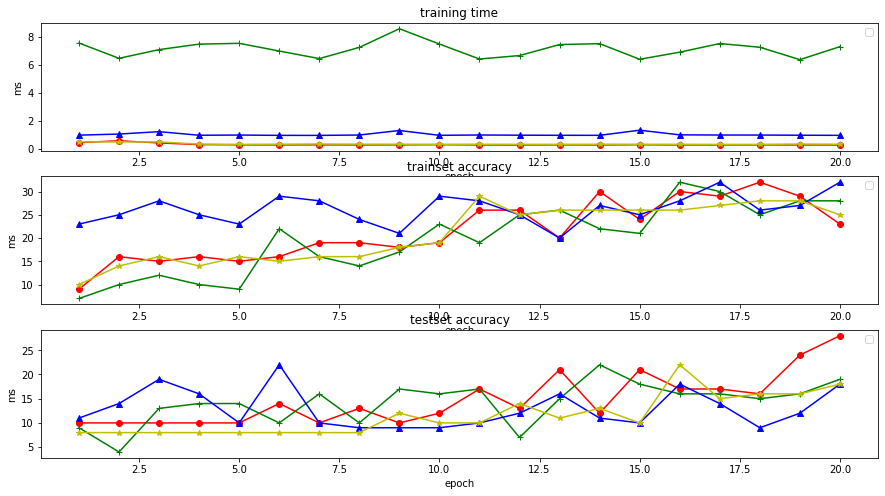

In [38]:
from matplotlib import pyplot as plt
x = list(range(1,21))
plt.figure(figsize = (15,8))
plt.subplot(3,1,1)
plt.title('training time')
plt.xlabel('epoch')
plt.ylabel('ms')
plt.plot(x, base_epoch_training_time, 'ro-', x, resnet18_epoch_training_time, 'g+-', x, resnet50_epoch_training_time, 'b^-',x, aug_base_epoch_training_time, 'y*-')
plt.legend()

plt.subplot(3,1,2)
plt.title('trainset accuracy')
plt.xlabel('epoch')
plt.ylabel('ms')
plt.plot(x, base_epoch_trainset_accuracy, 'ro-', x, resnet18_epoch_trainset_accuracy, 'g+-', x, resnet50_epoch_trainset_accuracy, 'b^-',x, aug_base_epoch_trainset_accuracy, 'y*-')
plt.legend()

plt.subplot(3,1,3)
plt.title('testset accuracy')
plt.xlabel('epoch')
plt.ylabel('ms')
plt.plot(x, base_epoch_testset_accuracy, 'ro-', x, resnet18_epoch_testset_accuracy, 'g+-', x, resnet50_epoch_testset_accuracy, 'b^-',x, aug_base_epoch_testset_accuracy, 'y*-')
plt.legend()

We can tell from the first graph that 2 CNN models run relatively faster comparing with ResNet models no matter implemented transfer learnign or not. For second one, it shows the trend that as more epochs are put in, the higher accuracy the models are likely to have. But the red one, base model, actually has a decline at the end. What is the interesting finding is that when it comes to the accuracy on test dataset, the red one shows an increase along with epochs. And the rest three model are providing the almost same output for test dataset.

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define the transforms to be applied to the data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define the function to compute the weak labels
def weak_labels(target):
    return torch.randint(low=0, high=10, size=(1,)).item()

# Load the CIFAR-10 dataset with weak labels
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train, target_transform=weak_labels)

# Define the weakly supervised classifier
class WeaklySupervisedClassifier(nn.Module):
    def __init__(self):
        super(WeaklySupervisedClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# Instantiate the weakly supervised classifier
classifier = WeaklySupervisedClassifier()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Train the classifier
for epoch in range(10):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_dataset):
        optimizer.zero_grad()
        outputs = classifier(inputs.unsqueeze(0))
        loss = criterion(outputs, targets.unsqueeze(0))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
